In [1]:
# primitive
import sys
import os
import pickle
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed
from pprint import pprint
import itertools
from collections import Counter
from time import time
from itertools import chain

# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# text
import MeCab
import spacy
import gensim
from gensim.models import KeyedVectors

# nn
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.vocab import Vocab

# **
# handmade libs
# *
src = '../../src'
if src not in sys.path: sys.path.append(src)

# constants
from const import *
constants = {k: v for k, v in locals().items() if k.isupper()}
pprint(constants)

# modules
# from my_tokenizer import get_tokenizer
from livedoor_dataset import LivedoorDataset
from myutils import get_n_label
from sudachi_tokenizer import SudachiTokenizer

{'DEVICE': 'cpu',
 'DIR_BIN': '/tmp/work/livedoor/bin',
 'DIR_DATA': '/tmp/work/livedoor/data',
 'DIR_LOG': '/tmp/work/livedoor/log',
 'DIR_MECAB_DIC': '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd',
 'DIR_MODEL': '/tmp/work/livedoor/model',
 'ROOT': '/tmp/work/livedoor',
 'SAMPLE_SENT': 'ワンマンライブに行きたい。',
 'SEED': 123,
 'TOKENIZER': 'mecab'}


# Load

In [2]:
# データセット読み込み
file = os.path.join(DIR_BIN, 'train_subset.pkl')
with open(file, 'rb') as f:
    train_dataset = pickle.load(f)

file = os.path.join(DIR_BIN, 'test_subset.pkl')
with open(file, 'rb') as f:
    test_dataset = pickle.load(f)

# vocab, embedding 読み込み
ENGINE = 'sudachi'
DICT = 'core'
DATASET = 'livedoor'
EMBEDDING = 'chive_mc90'
VERSION = 'intersection'
file_vocab = os.path.join(DIR_BIN, f'{ENGINE}.{DICT}.{DATASET}.{EMBEDDING}.{VERSION}.vocab.pkl')
file_embedding = os.path.join(DIR_BIN, f'{ENGINE}.{DICT}.{DATASET}.{EMBEDDING}.{VERSION}.embedding.pkl')
with open(file_vocab, 'rb') as f:
    vocab = pickle.load(f)
with open(file_embedding, 'rb') as f:
    embedding = pickle.load(f)

display(get_n_label(train_dataset).style.background_gradient('Blues', axis=1))
display(get_n_label(test_dataset).style.background_gradient('Blues', axis=1))
len(vocab)

0,0,1,2,3,4,5,6,7,8
1,713,607,685,709,668,413,705,676,717


0,0,1,2,3,4,5,6,7,8
1,186,163,185,161,202,98,159,166,153


48108

In [3]:
# pad
UNK = vocab.stoi['<unknown>']
PAD = vocab.stoi['<pad>']
print(UNK, PAD)

0 1


In [4]:
# 実験全体で class 作るべき。tokenizer, vocab, dataset をそれぞれ attributes としてもつ class

# Experiments

Class, Functions

<AxesSubplot:>

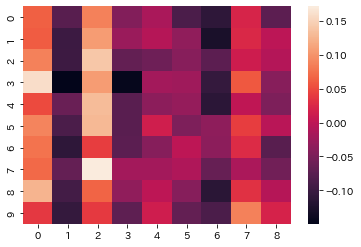

,1
0,
2,6
0,3
7,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<AxesSubplot:>

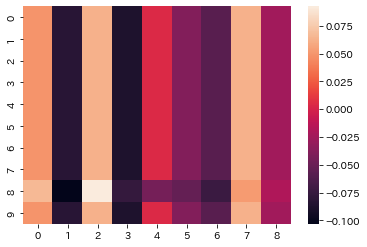

,1
0,
2,10


In [47]:
# todo: vocab, embedding 渡して vocab_size, embed_dim は渡さないようにする

class LSTMClassifier(nn.Module):
    
    def __init__(self, embedding, h_dim, class_dim):
        super(LSTMClassifier, self).__init__()
        torch.manual_seed(SEED)
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(embedding))
        self.lstm = nn.LSTM(embedding.shape[1], h_dim, batch_first=True)
        self.linear = nn.Linear(h_dim, class_dim)
        
    def forward(self, texts):
        '''Calculate an output sequence for input text
        
        Args:
          texts: 2 rank array of 
        Returns:
        
        '''
        text_embedding = self.embedding(texts)
        o, (h_n, c_n) = self.lstm(text_embedding)
        out = self.linear(h_n)
        return out

# test: 未学習段階で推論結果の偏りがないか
if 0==0:
    def viz_output(output):
        output = output.detach().squeeze().numpy()
        display(sns.heatmap(output))
        plt.show()
        freq = Counter(output.argmax(axis=1)).most_common()
        display(pd.DataFrame(freq).set_index(0).style.background_gradient('Blues'))
        
    # ランダムなトークン列
    # -> 偏る。仕方ないのか？
    lstm = LSTMClassifier(embedding, h_dim=100, class_dim=9)
    input_ = torch.tensor(np.random.randint(0, len(embedding), [10, 300]))
    output = lstm(input_)
    viz_output(output)
    
    # 実際のテキスト
    # -> ランダムなトークン列の場合より偏る。より秩序だっているから当然か？学習のためには、学習率を適切に設定するしかない？
    texts = [torch.tensor(text_pipeline(text)) for text in train_dataset[:10][1]]
    texts = pad_sequence(texts, batch_first=True, padding_value=PAD)

    output = lstm(torch.tensor(texts))
    viz_output(output)

# test: vectors[語]、lstm.embedding[vocab.stoi[語]] が一致するか？
if 0==1:
    vectors = gensim.models.KeyedVectors.load("/data/chive_v1.2mc90/chive-1.2-mc90_gensim/chive-1.2-mc90.kv")
    word = '私'
    v_chive = vectors[word]
    v_lstm  = lstm.embedding(torch.tensor(vocab.stoi[word])).numpy()
    print('Check result', all(v_chive==v_lstm))
    print('Head 10 elements:')
    print('v_chive:', v_chive[:10])
    print('v_lstm:', v_lstm[:10])

In [19]:
# mapping tokens to labels
tokenizer = SudachiTokenizer()
text_pipeline = lambda text: [vocab[token] for token in tokenizer.tokenized_text(text)]

# test: tokenizer で出力されるインデックスと、vocab.stoi[語] が一致するか？
if 0==0:
    texts = [
        'ワンマンライブに行きたい',
        'ヴェニスの商人を返してくださいよ'
    ]
    for text in texts:
        print(text_pipeline(text))
    print(vocab.stoi['ワンマン'])
    print(vocab.stoi['ヴェニス'], vocab.stoi['の'], vocab.stoi['商人'])

[17358, 1121, 4, 1057, 61]
[0, 2, 21728, 6, 2837, 7, 0, 63]
17358
0 2 21728


---

In [16]:
# 学習用 embedding 取得は word を介す必要がある

# vocab 構築時
# index <__ vocab.word                     # word から index へのマッパー（学習・推論に使用する）
#       \_> vocab.word __> vectors.vectors # word から embedding を取得し、index から embedding へのマッパーを構築

# 学習時
# token __> index __> embedding

# vocab の語に対応する embedding を vectors.vectors から取得すれば良い（not found の場合 zeros）


# 本質的には、embedding は辞書。list にすることで高速になっている辞書。

# [2:] の語に対応する embeddings の array を作る試行
# todo: KeyError; 辞書に存在しないはずの（vectors には少なくとも存在しない） ' ' が vocab には含まれており、エラー。
# -> 以下確認結果より、今回は unknown として捌く。以下の通り修正？
#    現：vocab + <unk> + <pad>
#    新：vocab と vectors の intersection + <unk> + <pad>
# ・Counter 時点で頻度確認する（どの文に、どのくらいの頻度で含まれるのか？なぜ ' ' が存在するのか？）
# 　-> 比較的低頻度語だった。今回は対応見送る。
# ・vocab に含まれ、vectors に含まれない語は他に存在するか？どのくらい存在するか？なぜ存在するか？
# 　-> 結構存在した。unknown に割り当てる。

---

In [21]:
# train
def iter_train(dataloader, model, loss_fn, optimizer):
    current_size = 0
    current_loss, current_correct = 0, 0
    
    for batch, (labels, texts) in enumerate(dataloader):
        
        # indexing
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
        # send to GPU
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)

        # pred
        pred = model(texts)[0]

        # get loss
        loss = loss_fn(pred, labels)

        # get gradient
        optimizer.zero_grad() # バッチごとに勾配をリセット
        loss.backward()

        # back propagate
        # 手動；todo: optimizer.step() の動作確認，デバッグ
        for layer_num, param in enumerate(model.parameters()):
            if layer_num==0:
                continue
            LR = optimizer.state_dict()['param_groups'][0]['lr']
            param.data -= LR * param.grad.data
#         optimizer.step()
        
        current_size += len(labels)
        current_loss += loss.item()
        current_correct += (pred.argmax(axis=1).squeeze()==labels).type(torch.int).sum().item()
        
        mean_loss = current_loss/current_size
        mean_correct = current_correct/current_size

        # logging
        if batch%30==0 and batch!=0:
            split = 'train'
            print(f'| {split*(1 if batch==0 else 0):5} | batch {batch:3d} '
                  f'| correct total: {mean_correct:0.8f} | loss total: {mean_loss:0.8f} |')
    
    return mean_correct, mean_loss

if DEVICE=='cuda':
    # 1 epoch sample execution
    sample_dataloader = DataLoader(train_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-4
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_train(sample_dataloader, model, loss_fn, optimizer)

In [22]:
# validate
def iter_test(dataloader, model, loss_fn):
    test_size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            pred = model(texts)[0]

            # get loss
            test_loss += loss_fn(pred, labels).item()

            # eval
            pred_labels = pred.argmax(axis=1).squeeze() # この squeeze は問題ないのか？
            correct += (pred_labels==labels).type(torch.int).sum().item()

    correct /= test_size # Epoch 終了時点の Accuracy（正答数 / テストサンプルサイズ）
    test_loss /= test_size # Epoch 終了時点の 1 サンプルあたり Loss 平均（Loss / テストサンプルサイズ）

    split = 'test'
    print(f'| {split:5} | accuracy: {correct:0.4f} | loss avg: {test_loss:6.8f} |', end='')
    
    return correct, test_loss

if DEVICE=='cuda':
    # sample execution
    sample_dataloader = DataLoader(test_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-2
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_test(sample_dataloader, model, loss_fn)

Execute

In [ ]:
# model setting
model_name = 'lstm'
embed_type = 'random'
embed_dim = 100
hidden_dim = 100

# training setting
batchsizes = [32]
lrs = [1e-1]
mos = [0.9]
n_epochss = [100]

for (batchsize, lr, mo, n_epochs) in itertools.product(batchsizes, lrs, mos, n_epochss):
    # dataloader
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batchsize,
                                  shuffle=True,)

    test_dataloader = DataLoader(test_dataset,
                                  batch_size=batchsize,
                                  shuffle=True,)

    # define network architecture
    model = LSTMClassifier(len(vocab), embed_dim, hidden_dim, 9).to(DEVICE)
    
    # modules
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mo)
    
    # train model
    result = []
    start = time()
    for epoch in range(n_epochs):

        print(f'{"-"*28} Epoch {epoch} {"-"*28}')
        train_acc, train_loss = iter_train(train_dataloader, model, loss_fn, optimizer)
        test_acc, test_loss = iter_test(test_dataloader, model, loss_fn)
        print(f' {time()-start:5.2f} sec |')
        result.append((epoch, train_acc, train_loss, test_acc, test_loss))

    print('done!')
    
    # **
    # save
    # *
    filename_base = f'emb={embed_type}&edim={embed_dim:03d}' \
                    f'&model={model_name}&hdim={hidden_dim:03d}' \
                    f'&batchsize={batchsize:03d}' \
                    f'&optim=sgd&lr={lr:.5f}&mo={mo:.1f}' \
                    f'&epochs={n_epochs:4d}' \
                    f'&shuffle=True'
    filename_model = os.path.join(DIR_MODEL, filename_base+'.pth')
    filename_log = os.path.join(DIR_LOG, filename_base+'.csv')

    # save model
    if not os.path.isfile(filename_model):
        torch.save(model, filename_model)
        print(f'{filename_model} : created')
    else:
        print(f'{filename_model} : exists')

    # save log
    if not os.path.isfile(filename_log):
        result = pd.DataFrame(result).rename(columns={0: 'epoch',
                                                      1: 'train_acc',
                                                      2: 'train_loss',
                                                      3: 'test_acc',
                                                      4: 'test_loss'})
        result.to_csv(filename_log, index=False)
        print(f'{filename_log} : created')
    else:
        print(f'{filename_log} : exists')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


---------------------------- Epoch 0 ----------------------------


過学習、バッチ shuffle してなかったからでは？

そもそもおかしいところ
- 特定のラベルに推論結果が偏る
- test なのに正答しない

なやみ
- 過学習する
- 収束しない
- ９値分類で推定結果が１つだけに偏る；１epoch 目からそんな感じ．初期値がかたよってるから？（散らばらせることできる？）

- embedding の 重みって，分散表現とべつであるか？

- model 生成の順序を修正したから改善した？Embedding.require_grad=False を無効にしたから改善した？（先に進む前に，一度確認すべき）
- 32, 64 128 で 1e-0 で試してみる

- train, test ともに，モデルの出力結果（Loss()に入れる直前の生の出力値）を受け取って評価するつくりに変更
- → train, test をスタンドアロンに動かせるようになる．
- → テストだけ実行して，未学習時点における推論結果の偏り有無を確認する（偏ってたら，パラメータ初期値が好ましくないという仮説の立証に一歩近づく）

embedding の weight 更新 True にして試行

# Evaluation

In [19]:
%%time
def predict_dataloader(dataloader, model):

    y = []
    
    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            y.append(list(labels.numpy()))
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            if batch==0:
                y_pred = model(texts)[0].cpu().numpy()
            else:
                y_pred = np.append(y_pred, model(texts)[0].cpu().numpy(), axis=0)
    
    return np.array(list(itertools.chain.from_iterable(y))), y_pred#.argmax(axis=1)

f = 'emb=random&edim=300&model=lstm&hdim=100&batchsize=128&optim=sgd&lr=0.00003&mo=0.9&epochs=1.pth'
model = torch.load(os.path.join(DIR_MODEL, f))

test_dataloader = DataLoader(test_dataset,
                              batch_size=128,
                              shuffle=False,)
y, y_pred = predict_dataloader(test_dataloader, model)
sns.heatmap(pd.crosstab(y, y_pred))

ValueError: Data must be 1-dimensional

In [20]:
y_pred

array([[ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404025,  0.07488791],
       [ 0.10310535, -0.05537033,  0.01440569, ...,  0.02722622,
         0.00404026,  0.07488791],
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791],
       ...,
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791],
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791],
       [ 0.10310535, -0.05537033,  0.0144057 , ...,  0.02722622,
         0.00404026,  0.07488791]], dtype=float32)

In [ ]:
pred_with_word_embedding(model, )

# Primitive model

create feature dataset

In [26]:
def get_embedding_table(dataloader):
    X, y = [], []
    for batch, (labels, texts) in enumerate(dataloader):
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)
        emb = model.embedding(texts).detach().cpu().numpy().mean(axis=1)
        X.append(emb)
        y.append(labels.detach().cpu().numpy())
    
    X = np.array(list(itertools.chain.from_iterable(X)))
    y = np.array(list(itertools.chain.from_iterable(y)))
        
    return X, y

model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
X_train, y_train = get_embedding_table(train_dataloader)
X_test, y_test = get_embedding_table(test_dataloader)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5893, 300) (5893,)
(1473, 300) (1473,)


feature overview

(9, 300)


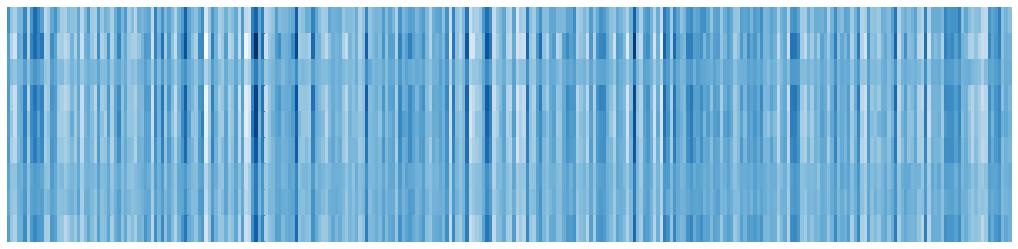

In [27]:
%matplotlib inline

def show(embedding):
    w = 18
    h = embedding.shape[0] * (w / 300) * 8

    fig = plt.figure(figsize=(w, h))
    ax = fig.add_subplot(1, 1, 1)

    print(embedding.shape)
    sns.heatmap(pd.DataFrame(embedding), cbar=False, xticklabels=False, yticklabels=False, cmap='Blues')

    plt.show()
    return

df = pd.DataFrame(X_train)
show(df.groupby(y_train).mean())

ベンチマーク；SVM で 82 %

In [28]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sum(y_pred == y_test) / len(y_test)

0.8268839103869654

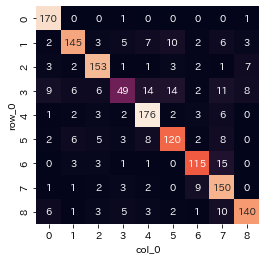

In [29]:
%matplotlib inline

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(pd.crosstab(y_test, y_pred), cbar=False, annot=True, fmt='d')
plt.show()

# Work